In [1]:
# general purpose packages
import pandas as pd
import numpy as np
import os
from datetime import datetime
import pickle

# visualization related packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import GridSearchCV

# Classifier Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Model related packages
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import 
from sklearn.multiclass import OneVsRestClassifier

# Presenting Results
from prettytable import PrettyTable

# for loading the sparse matrix features
import scipy.sparse

# Configs

In [2]:
# set sample size
sample_size = -1 # set -1 for full size

# path for train, test
df_train_label_path = './data/Final_train_df_label.csv'
df_test_label_path = './data/Final_test_df_label.csv'
# path of final features frames
final_train_feat_path = './data/train_feat_sparse_matrix.npz'
final_test_feat_path = './data/test_feat_sparse_matrix.npz'

# Util Functions

In [3]:
def evaluate_model(model, X, y, title_suffix=str()):
    
    # get prediction and its probability
    predicted_labels = model.predict(X)
    #predicted_probs = model.predict_proba(X)
    
    # get evaluation scores (micro averaged)
    micro_eval_array = precision_recall_fscore_support(y, predicted_labels,
                                                       average='micro')[0:-1]
    
    
    # get evaluation scores (macro averaged)
    macro_eval_array = precision_recall_fscore_support(y, predicted_labels,
                                                       average='macro')[0:-1]
    
    eval_df = pd.DataFrame([micro_eval_array, macro_eval_array], 
                           columns=['Precision', 'Recall', 'F1_Score'])
    eval_df.index = ['Micro-Averaged', 'Macro-Averaged']
    
    # convert it to percentage
    eval_df *= 100.0
    
    # plot the classification report
    sns.heatmap(eval_df, annot=True, annot_kws={'size': 16}, fmt='.4f', cmap='YlGnBu',
                   cbar_kws={'label': 'Percentage', 'format':'%.2f'})
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    
    plt.xlabel('Metrics')
    plt.ylabel('Average Type')
    plt.title('Classification Report -' + title_suffix)
    plt.show()
    
    # get the performace metrics
    micro_f1_score = '{0:.4f}'.format(eval_df.loc['Micro-Averaged', 'F1_Score'])
    macro_f1_score = '{0:.4f}'.format(eval_df.loc['Macro-Averaged', 'F1_Score'])
    
    # get accuracy & haming loss
    accuracy = accuracy_score(y, predicted_labels)
    ham_loss = hamming_loss(y, predicted_labels)
    
    print('Accuracy : %f \t Hamming loss : %f'%(accuracy, ham_loss,))
    
    return (ham_loss, micro_f1_score,)

# Data

In [4]:
# Read label inforamtion
df_train = pd.read_csv(df_train_label_path, index_col=False)
df_test = pd.read_csv(df_test_label_path, index_col=False)

# read featue data
X_train = scipy.sparse.load_npz(final_train_feat_path)
X_test = scipy.sparse.load_npz(final_test_feat_path)

if sample_size > 0:
    # set sample for train
    df_train = df_train.iloc[0:sample_size]
    df_train = df_train.reset_index(drop=True)
    # set sample for test
    df_test = df_test.iloc[0:sample_size]
    df_test = df_test.reset_index(drop=True)
    # sample features
    X_train = X_train[0:sample_size, :]
    X_test = X_test[0:sample_size, :]
    
    
    
print('Shape of train features shape :', X_train.shape)
print('Shape of features shape :', X_test.shape)

Shape of train features shape : (210000, 12526)
Shape of features shape : (90000, 12526)


In [5]:
# load the label names from the pickle file
#load model from disk
pickle_in = open("./data/so_multilabels.pkl","rb")
labels_list = pickle.load(pickle_in)
pickle_in.close()
print('Multilabel list', labels_list[30:40])

Multilabel list ['application', 'architecture', 'arraylist', 'arrays', 'asp-classic', 'asp.net', 'asp.net-mvc', 'asp.net-mvc-2', 'asp.net-mvc-3', 'asp.net-mvc-4']


## Convert labels to One Hot Encoded Format

In [6]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary='true')
vectorizer.fit([' '.join(labels_list)])
label_names_list = list(vectorizer.get_feature_names())

In [7]:
# transform the feature columns
y_train = vectorizer.transform(df_train['Tags'])
y_test = vectorizer.transform(df_test['Tags'])

# prepare train test features data frames 
y_train = pd.DataFrame(y_train.toarray(), columns=label_names_list)
y_test = pd.DataFrame(y_test.toarray(), columns=label_names_list)

# sample y_train
y_train.head()

,.htaccess,.net,.net-3.5,.net-4.0,2010,3d,abstract-algebra,actionscript,actionscript-3,active-directory,...,wpf,xaml,xcode,xcode4,xhtml,xml,xpath,xslt,youtube,zend-framework
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
y_train.sum(axis=0).min()

171

In [9]:
y_test.sum(axis=0).min()

69

# Models

## A) Logistic regression(OvR)

In [10]:
def get_best_hyperparam_OVR_LogisticRegression(param_dict, X, y, random_search=False):
    
    # set the scoring function
    final_scorer = 'f1-micro'
    
    # declare a scoring dictionary
    score_dict = {
        'f1-micro': make_scorer(score_func=f1_score, greater_is_better=True,
                                     needs_proba=False, needs_threshold=False, average='micro')
    }
        
    
     #Declare the metric as  'minimization' or 'maximization'
    optimization_dict = {
        'f1-micro' : 'maximization'
    }
    
    # Set a data partitioning strategy
    cv_data = 3
        
     
    # declare model
    #log_reg = LogisticRegression()
    log_reg = SGDClassifier(loss='log', penalty='l1', max_iter=1e+03, tol=1e-03)
    model = OneVsRestClassifier(log_reg)
    
    if random_search:
        search_cv = RandomizedSearchCV(estimator=model, param_distributions=param_dict, 
                                       cv=cv_data, scoring=score_dict, refit=False, 
                                       return_train_score=True, n_iter=6, n_jobs=-1)
        
    else:
        # declare grid search CV object
        search_cv = GridSearchCV(estimator=model, param_grid=param_dict, cv=cv_data,
                                 scoring=score_dict, refit=False, 
                                 return_train_score=True, n_jobs=-1)
    
    # fit to the data
    search_cv.fit(X, y)
    
    
    # get total number of param settings
    param_list = list(param_dict.keys())
    param_field_list = ['param_' + item for item in param_list]
    
    # get list of train metric list
    train_metric_list = ['mean_train_' + item for item in score_dict.keys()]
    # get list of test metric list
    test_metric_list = ['mean_test_' + item for item in score_dict.keys()]
    
    # get number of rows in the search cv data frame
    num_rows = len(search_cv.cv_results_['params'])
        
    # create the grid search info df  
    grid_info_df = pd.DataFrame(search_cv.cv_results_, index=range(num_rows))
    
    # prepare a list of reqired columns
    required_columns = ['params'] + param_field_list + train_metric_list + \
                       test_metric_list
    
    # slice the data frame to only required columns
    grid_info_df = grid_info_df[required_columns]
    
    # process individual metrics
    for metric, optimization in optimization_dict.items():
        if optimization == 'minimization':
            grid_info_df['mean_train_' + metric] *= -1
            grid_info_df['mean_test_' + metric] *= -1
            
            
    # Find the best hyperparam & its corresponding scores
    if optimization_dict[final_scorer] == 'minimization':
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmin(),:] 
    else:
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmax(),:]
        
    # best hyperparam & corresponding scores
    best_hyperparam = best_hyperparam_record['params']
    best_train_score = best_hyperparam_record['mean_train_'+ final_scorer]
    best_validation_score = best_hyperparam_record['mean_test_'+ final_scorer]
    
    # plot the hyper params 
    if len(param_list) == 1:
        
        # extract individual fiedls
        x_vals = np.log10(grid_info_df[param_field_list[0]].tolist())
        y_vals_tr = grid_info_df['mean_train_' + final_scorer].tolist()
        y_vals_val = grid_info_df['mean_test_' + final_scorer].tolist()
        
        # plot train, validation performances
        plt.plot(x_vals, y_vals_tr, label='Train', color='r', marker='o', linestyle='-')
        plt.plot(x_vals, y_vals_val, label='Validation', color='b', marker='o', linestyle='-')
        plt.xlabel('Log Hyper Params -' + param_list[0])
        plt.ylabel(final_scorer)
        plt.legend()
        plt.title('LogisticRegression OvR - Hyperparam Train v/s Validation Scores')
        plt.show()
        
        
    # Heatmap plot for pair of hyperparam values  
    elif len(param_list) == 2:
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_train_' + final_scorer , 
                                      fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('LogisticRegression OvR - Hyperparams Scores - Train')
        plt.show()
        
        print('\n'*3)
        
        # Test hyperparam
        
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_test_' + final_scorer, fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('LogisticRegression OvR - Hyperparams Scores - Validation')
        plt.show()
        
    else:
        print(grid_info_df)
    
    print('Best hyperparam value: ', best_hyperparam, 'Best Train Score: ', best_train_score, 
          'Best Validation Score: ', best_validation_score)
   
          
    #best_mse_train = best_hyperparam_record['mean_train_MSE']
    #best_mse_validation = best_hyperparam_record['mean_test_MSE']
    
    # return tuple
    ret_tuple = (best_hyperparam, best_train_score, best_validation_score,)
    
    
    return ret_tuple

### 1. Find the best Hyperparam

2019-06-27 00:47:18.744195  Hyperparam Tuning of Logistic Regression OvR started


/home/amd_3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/amd_3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/amd_3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/amd_3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/amd_3/anaconda3/lib/python3.6/site-packages/sklearn/metric

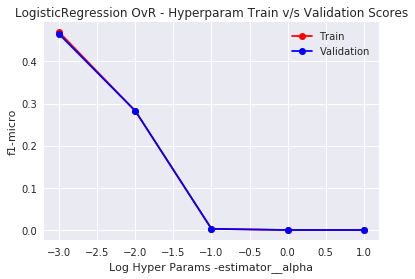

Best hyperparam value:  {'estimator__alpha': 0.001} Best Train Score:  0.4689696589260479 Best Validation Score:  0.4642311287828081
2019-06-27 01:15:04.100310  Hyperparam Tuning of Logistic Regression OvR completed


In [11]:
param_dict_lr_ovr = {'estimator__alpha': [1e-03, 1e-02, 1e-01, 1e+00, 1e+01]}
print(datetime.now() ,' Hyperparam Tuning of Logistic Regression OvR started')
hyp_tuned_info_lgr = get_best_hyperparam_OVR_LogisticRegression(param_dict_lr_ovr, 
                                                            X_train, y_train)
print(datetime.now() ,' Hyperparam Tuning of Logistic Regression OvR completed')
best_hyp_lgr, best_tr_score_lgr, best_val_score_lgr = hyp_tuned_info_lgr

### 2. Train the model with best hyperparam

In [12]:
log_reg = SGDClassifier(loss='log', alpha=best_hyp_lgr['estimator__alpha'], penalty='l1', 
                        max_iter=1e+03, tol=1e-03)
log_reg_ovr = OneVsRestClassifier(log_reg, n_jobs=-1)

print(datetime.now() ,' Training of Logistic Regression OvR completed')
log_reg_ovr.fit(X_train, y_train)
print(datetime.now() ,' Training of Logistic Regression OvR completed')

# save model to disk
pickle_out = open("./model/logistic_regression_ovr.pkl","wb")
pickle.dump(log_reg_ovr, pickle_out)
pickle_out.close()

2019-06-27 01:15:04.107993  Training of Logistic Regression OvR completed
2019-06-27 01:20:09.674191  Training of Logistic Regression OvR completed


/home/amd_3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


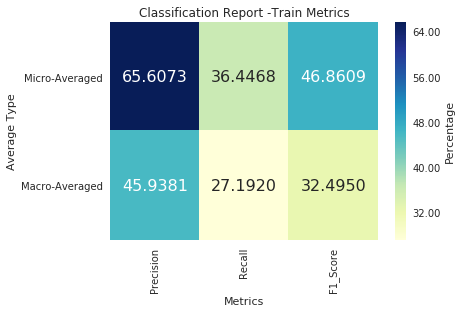

Accuracy : 0.157210 	 Hamming loss : 0.003309


In [13]:
#load model from disk
pickle_in = open("./model/logistic_regression_ovr.pkl","rb")
log_reg_ovr = pickle.load(pickle_in)
pickle_in.close()

# evaluate the trained model on train data
table_entry_train_lgr = evaluate_model(log_reg_ovr, X_train, y_train, 'Train Metrics')

### 3. Test the model

/home/amd_3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


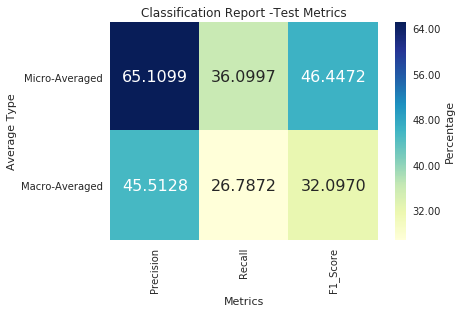

Accuracy : 0.154867 	 Hamming loss : 0.003327


In [14]:
# evaluate the trained model on test data
table_entry_test_lgr = evaluate_model(log_reg_ovr, X_test, y_test, 'Test Metrics')

In [15]:
table_entry_lgr = ('Logistic Regression (OvR)', best_hyp_lgr,) + \
                  (table_entry_train_lgr[1],) + (table_entry_test_lgr[1],)

## B) Linear SVM (OvR)

In [16]:
def get_best_hyperparam_OVR_SVC(param_dict, X, y, random_search=False):
    
    # set the scoring function
    final_scorer = 'f1-micro'
    
    # declare a scoring dictionary
    score_dict = {
        'f1-micro': make_scorer(score_func=f1_score, greater_is_better=True,
                                     needs_proba=False, needs_threshold=False, average='micro')
    }
        
    
     #Declare the metric as  'minimization' or 'maximization'
    optimization_dict = {
        'f1-micro' : 'maximization'
    }
    
    
    # Set a data partitioning strategy
    cv_data = 3
        
     
    # declare model
    svm = SGDClassifier(loss='hinge', penalty='l1', max_iter=1e+03, tol=1e-03)
    model = OneVsRestClassifier(svm)
    
    if random_search:
        search_cv = RandomizedSearchCV(estimator=model, param_distributions=param_dict, 
                                       cv=cv_data, scoring=score_dict, refit=False, 
                                       return_train_score=True, n_iter=6, n_jobs=-1)
        
    else:
        # declare grid search CV object
        search_cv = GridSearchCV(estimator=model, param_grid=param_dict, cv=cv_data,
                                 scoring=score_dict, refit=False, 
                                 return_train_score=True, n_jobs=-1)
    
    # fit to the data
    search_cv.fit(X, y)
    
    
    # get total number of param settings
    param_list = list(param_dict.keys())
    param_field_list = ['param_' + item for item in param_list]
    
    # get list of train metric list
    train_metric_list = ['mean_train_' + item for item in score_dict.keys()]
    # get list of test metric list
    test_metric_list = ['mean_test_' + item for item in score_dict.keys()]
    
    # get number of rows in the search cv data frame
    num_rows = len(search_cv.cv_results_['params'])
        
    # create the grid search info df  
    grid_info_df = pd.DataFrame(search_cv.cv_results_, index=range(num_rows))
    
    # prepare a list of reqired columns
    required_columns = ['params'] + param_field_list + train_metric_list + \
                       test_metric_list
    
    # slice the data frame to only required columns
    grid_info_df = grid_info_df[required_columns]
    
    # process individual metrics
    for metric, optimization in optimization_dict.items():
        if optimization == 'minimization':
            grid_info_df['mean_train_' + metric] *= -1
            grid_info_df['mean_test_' + metric] *= -1
            
            
    # Find the best hyperparam & its corresponding scores
    if optimization_dict[final_scorer] == 'minimization':
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmin(),:] 
    else:
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmax(),:]
        
    # best hyperparam & corresponding scores
    best_hyperparam = best_hyperparam_record['params']
    best_train_score = best_hyperparam_record['mean_train_'+ final_scorer]
    best_validation_score = best_hyperparam_record['mean_test_'+ final_scorer]
    
    # plot the hyper params 
    if len(param_list) == 1:
        
        # extract individual fiedls
        x_vals = np.log10(grid_info_df[param_field_list[0]].tolist())
        y_vals_tr = grid_info_df['mean_train_' + final_scorer].tolist()
        y_vals_val = grid_info_df['mean_test_' + final_scorer].tolist()
        
        # plot train, validation performances
        plt.plot(x_vals, y_vals_tr, label='Train', color='r', marker='o', linestyle='-')
        plt.plot(x_vals, y_vals_val, label='Validation', color='b', marker='o', linestyle='-')
        plt.xlabel('Log Hyper Params -' + param_list[0])
        plt.ylabel(final_scorer)
        plt.legend()
        plt.title('SVC OvR - Hyperparam Train v/s Validation Scores')
        plt.show()
        
        
    # Heatmap plot for pair of hyperparam values  
    elif len(param_list) == 2:
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_train_' + final_scorer , 
                                      fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('SVC OvR - Hyperparams Scores - Train')
        plt.show()
        
        print('\n'*3)
        
        # Test hyperparam
        
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_test_' + final_scorer, fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('SVC OvR - Hyperparams Scores - Validation')
        plt.show()
        
    else:
        print(grid_info_df)
    
    print('Best hyperparam value: ', best_hyperparam, 'Best Train Score: ', best_train_score, 
          'Best Validation Score: ', best_validation_score)
   
          
    #best_mse_train = best_hyperparam_record['mean_train_MSE']
    #best_mse_validation = best_hyperparam_record['mean_test_MSE']
    
    # return tuple
    ret_tuple = (best_hyperparam, best_train_score, best_validation_score,)
    
    
    return ret_tuple

### 1. Find the best Hyperparam

2019-06-27 01:21:06.445062  Hyperparam Tuning of SVC OvR started


/home/amd_3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/amd_3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/amd_3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/amd_3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/amd_3/anaconda3/lib/python3.6/site-packages/sklearn/metric

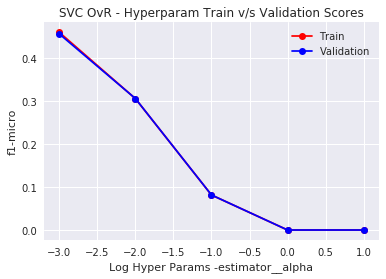

Best hyperparam value:  {'estimator__alpha': 0.001} Best Train Score:  0.4599030081943924 Best Validation Score:  0.4562269375232664
2019-06-27 02:00:50.698555  Hyperparam Tuning of SVC OvR completed


In [17]:
param_dict_svm_ovr = {'estimator__alpha': [1e-03, 1e-02, 1e-01, 1e+00, 1e+01]}

print(datetime.now() ,' Hyperparam Tuning of SVC OvR started')
hyp_tuned_info = get_best_hyperparam_OVR_SVC(param_dict_svm_ovr, X_train, y_train)
print(datetime.now() ,' Hyperparam Tuning of SVC OvR completed')


best_hyp_svm, best_tr_score_svm, best_val_score_svm = hyp_tuned_info

### 2. Train the model with best hyperparam

In [18]:
svm = SGDClassifier(loss='log', alpha=best_hyp_svm['estimator__alpha'], penalty='l1', 
                        max_iter=1e+03, tol=1e-03)
svm_ovr = OneVsRestClassifier(svm, n_jobs=-1)

print(datetime.now() ,' Training of SVC OvR started')
svm_ovr.fit(X_train, y_train)
print(datetime.now() ,' Training of SVC OvR completed')

# save model to disk
pickle_out = open("./model/svc_ovr.pkl","wb")
pickle.dump(svm_ovr, pickle_out)
pickle_out.close()

2019-06-27 02:00:50.706338  Training of SVC OvR started
2019-06-27 02:05:53.997662  Training of SVC OvR completed


/home/amd_3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


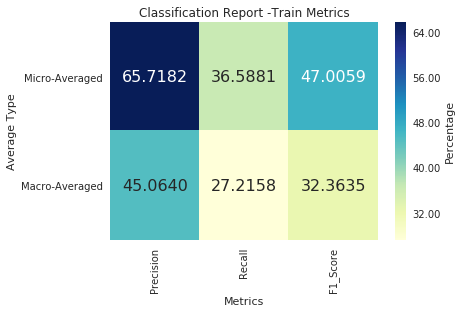

Accuracy : 0.158486 	 Hamming loss : 0.003303


In [19]:
#load model from disk
pickle_in = open("./model/svc_ovr.pkl","rb")
svm_ovr = pickle.load(pickle_in)
pickle_in.close()

# evaluate the trained model on train data
table_entry_train_svm = evaluate_model(svm_ovr, X_train, y_train, 'Train Metrics')

### 3. Test the model

/home/amd_3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


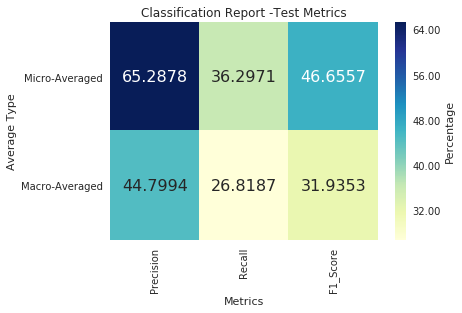

Accuracy : 0.156033 	 Hamming loss : 0.003317


In [20]:
# evaluate the trained model on test data
table_entry_test_svm = evaluate_model(svm_ovr, X_test, y_test, 'Test Metrics')

In [21]:
table_entry_svm = ('SVM Classifier (OvR)', best_hyp_svm,) + \
                  (table_entry_train_svm[1],) + (table_entry_test_svm[1],)

# Results

In [22]:
Pret_table = PrettyTable()
Pret_table.field_names = ['Model', 'Hyperparam', 
                          'Micro-Avg-F1(Train)', 
                          'Micro-Avg-F1(Test)']

Pret_table.title = 'Multilabelled Classifier Results Summary'

# add model results
Pret_table.add_row(table_entry_lgr)
Pret_table.add_row(table_entry_svm)
print(Pret_table)

+----------------------------------------------------------------------------------------------------+
|                              Multilabelled Classifier Results Summary                              |
+---------------------------+-----------------------------+---------------------+--------------------+
|           Model           |          Hyperparam         | Micro-Avg-F1(Train) | Micro-Avg-F1(Test) |
+---------------------------+-----------------------------+---------------------+--------------------+
| Logistic Regression (OvR) | {'estimator__alpha': 0.001} |       46.8609       |      46.4472       |
|    SVM Classifier (OvR)   | {'estimator__alpha': 0.001} |       47.0059       |      46.6557       |
+---------------------------+-----------------------------+---------------------+--------------------+


# Procedure Summary

<ul>
<li> Class label is enoded in a format suitable for One vs Rest classification </li>
<li> Hyperparameter is tuned for each of the One Vs Rest Classsifiers</li>
<li> Each classifier is trained with the best hyperpatam setting obtained </li>
<li> Two models are evaluated on a test dataset </li>
</ul>

# Conclusion

<ul>
<li> The best model obtaind is the SVM OvR classifier with 46.6557 micro f1-score</li>
<li> The performace of the Logistic classifier (with 46.4472 micro f1-score) is also very close to SVM </li>
<li> The difference between the train, test f1-scores are very less for both the model, this is an
     indication that the model is generalizing well </li>
<li> More feature engineering methods can be tried to improve the score furhter </li>
</ul>